In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import h5py as h5
import numpy as np
import os

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use("../paper.mplstyle")

from scipy.interpolate import interp1d
from scipy.optimize import ridder

import sys
sys.path.append("../")
sys.path.append("../../ASTERIA/python/")
from ic_sn_hnl import parameterized_flux_from_files, units
from ic_sn_hnl.flux.parametrize_flux import compute_moment, Params, parameterized_flux_from_h5, deserialize
from ic_sn_hnl.flux.sanitize_flux import sanitize_flux

from tqdm import tqdm

import os
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"

In [4]:
infiles = glob("../data/magnetic_moment/from_yingying/*.csv")
for infile in tqdm(infiles):
    outfile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    a = np.genfromtxt(infile, delimiter=",")
    a[:, 2] = a[:, 2] / 6
    np.save(outfile, a)

100%|██████████| 38/38 [05:58<00:00,  9.44s/it]


In [6]:
outfile = "./data/magnetic_moment_fluxes.h5"

if not os.path.exists(outfile):
    with h5.File(outfile, "w") as _:
        pass

for infile in tqdm(infiles):
    key = infile.split("/")[-1].replace(".csv", "")
    infile = f"./data/{infile.split('/')[-1].replace('csv', 'npy')}"
    arr = np.load(infile)
    times = np.sort(np.unique(arr[:, 0])) * units["second"]
    energies = np.sort(np.unique(arr[:, 1])) * units["MeV"]
    fluxes = np.empty(times.shape + energies.shape + (3,),)

    for idx in range(len(times)):
        flux = arr[idx*len(energies):(idx+1)*len(energies), 2] / units["MeV"] / units["second"]
        flux = np.where(flux >= 0, flux, 0) # Sometimes numerical issues can sneak in to give negative fluxes
        fluxes[idx, :, 0] = flux # nue
        fluxes[idx, :, 1] = flux # nuebar
        fluxes[idx, :, 2] = flux # nux per flavor

    with h5.File(outfile, "r+") as h5f:

        if key in h5f.keys():
            del h5f[key]

        h5f.create_group(key)
        h5f[key].create_dataset("energies", data=energies)
        h5f[key].create_dataset("times", data=times)
        h5f[key].create_dataset("fluxes", data=fluxes)

100%|██████████| 38/38 [00:23<00:00,  1.62it/s]


In [7]:
key = "sm_flux"
infile = "data/sm_flux.h5"
serialize_file = "./data/serialized_sm_flux.h5"

with h5.File(serialize_file) as h5f:
    done_keys = list(h5f.keys())

with h5.File(infile, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=100)
        pflux.serialize(serialize_file, key)

100%|██████████| 1/1 [00:00<00:00, 5398.07it/s]


In [15]:
infile = "data/magnetic_moment_fluxes.h5"
serialize_file = "./data/serialized_magnetic_moment_fluxes.h5"

thin = 10

done_keys = []
if os.path.exists(serialize_file):
    with h5.File(serialize_file) as h5f:
        done_keys = list(h5f.keys())

with h5.File(infile, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=thin, track=False)
        pflux.serialize(serialize_file, key)

100%|██████████| 38/38 [00:00<00:00, 3669.39it/s]


In [16]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
TMINS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
DTS = np.linspace(0.001, 5, 401) * units["second"]
def find_significance_matrix(sig_hits, sm_hits, bg_hits, times, tmins=TMINS, dts=DTS):
    significance = np.full(tmins.shape + dts.shape, np.nan)

    for idx, tmin in enumerate(tmins):
        for jdx, dt in enumerate(dts):
            m = np.logical_and(tmin < times, times < tmin+dt)
            if not m.sum():
                continue
            significance[idx, jdx] = likelihood(sig_hits[m], sm_hits[m], bg_hits[m])
    return significance, tmins, dts

def likelihood(sig_hits, sm_hits, bg_hits):
    n_obs = (bg_hits + sm_hits).sum()
    n_exp = (sig_hits + bg_hits + sm_hits).sum()
    llh = 2 * (n_exp - n_obs)
    if n_obs > 0:
        llh += 2 * n_obs * np.log(n_obs / n_exp)
    return llh

In [20]:
with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)
out = {}

with h5.File("./data/serialized_magnetic_moment_fluxes.h5", "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", ""))
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}")
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        out[mass].append((coupling, significance[m].max()))

100%|██████████| 38/38 [24:16<00:00, 38.34s/it]


100.0
[1.00000000e-14 1.58489319e-14 5.01187234e-14 1.00000000e-13]


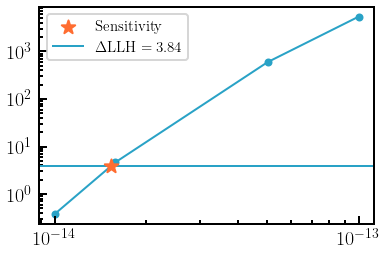

10.0
[5.01187234e-14]


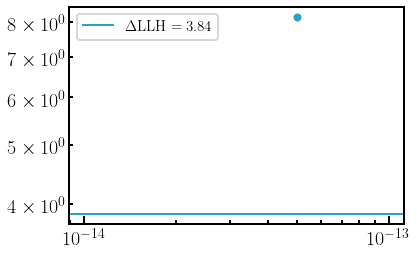

150.0
[5.01187234e-15 1.00000000e-14]


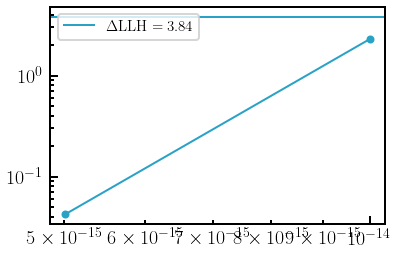

1.0
[1.58489319e-14 3.16227766e-14 5.01187234e-14 1.00000000e-13
 5.01187234e-13]


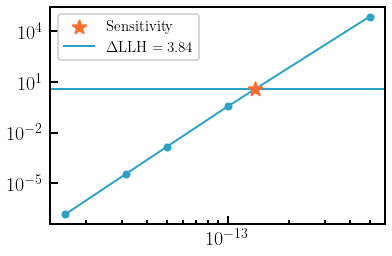

200.0
[3.16227766e-15 5.01187234e-15 6.30957344e-15 7.94328235e-15
 1.00000000e-14 3.16227766e-14 1.00000000e-13 5.01187234e-13]


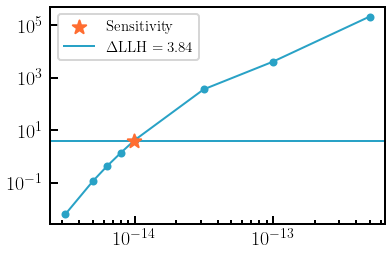

300.0
[3.16227766e-15 5.01187234e-15 1.00000000e-14 1.58489319e-14]


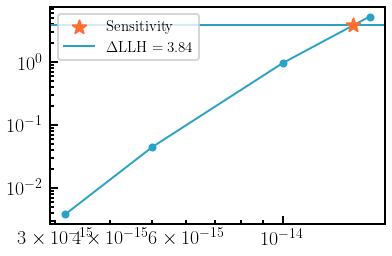

340.0
[3.16227766e-15 5.01187234e-15 1.00000000e-14 1.58489319e-14
 3.16227766e-14 1.00000000e-13 5.01187234e-13]


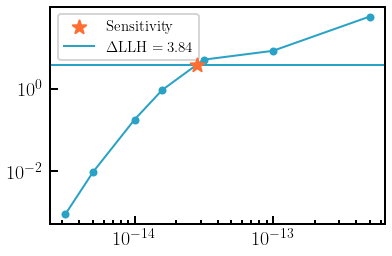

360.0
[1.25892541e-14 1.58489319e-14 3.16227766e-14]


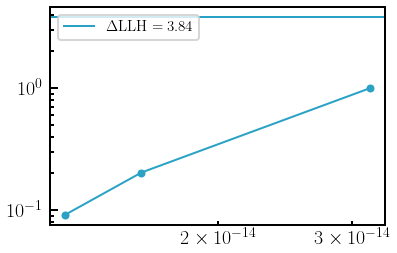

380.0
[1.00000000e-14 3.16227766e-14 1.00000000e-13 5.01187234e-13]


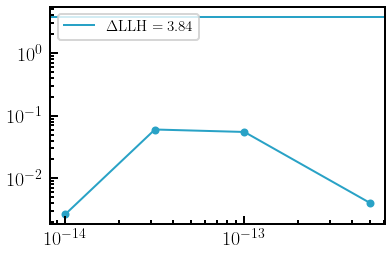

In [42]:
sensitivities = []

for k, v in out.items():
    print(k)
    v = sorted(v)
    _, ax = plt.subplots()
    
    couplings = np.power(10, [x[0] for x in v])
    significnces = [x[1] for x in v]
    
    plot_sens = True
    try:
        interp = interp1d(np.log(couplings), np.log(significnces))
        f = lambda lc: np.exp(interp(lc)) - 3.841
        res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
        sens = np.exp(res)
        sensitivities.append((k, sens))
    except ValueError:
        plot_sens = False
        
    ax.plot(couplings, significnces)
    ax.scatter(couplings, significnces)
    if plot_sens:
        ax.scatter([sens], [np.exp(interp(res))], marker="*", zorder=10, s=200, label="Sensitivity")
    ax.axhline(3.841, label=r"$\Delta\mathrm{LLH}=3.84$")
    print(couplings)
    ax.loglog()
    ax.legend(fontsize=15, loc=2)
    # ax.set_xlim(1e-14, 6e-14)
    # ax.set_ylim(1e-6, 8)
    
    plt.savefig(f"./figures/magnetic_moment_sensitivities_{int(k)}MeV.pdf")
    plt.show()
    
    

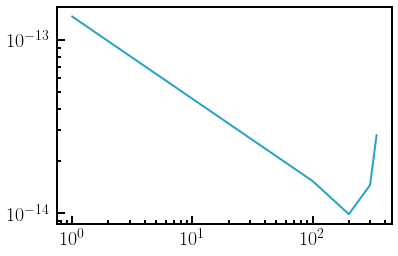

In [29]:
sensitivities = sorted(sensitivities)

plt.plot([x[0] for x in sensitivities], [x[1] for x in sensitivities])

plt.loglog()
plt.show()
